In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
def extract_eval_value(state):
    # Define the desired columns
    keys = [
        "epoch", "step", "eval_accuracy", "eval_f1", "eval_loss",
        "eval_matthews_correlation", "eval_precision", "eval_recall"
    ]
    
    # Extract logs that contain 'eval_loss'
    logs = [
        {key: log.get(key, None) for key in keys}
        for log in state["log_history"]
        if "eval_loss" in log
    ]
    
    # Create DataFrame
    df = pd.DataFrame(logs)
    df.rename(columns={
        "epoch": "Epoch",
        "step": "Step",
        "eval_accuracy": "Accuracy",
        "eval_f1": "F1",
        "eval_loss": "Loss",
        "eval_matthews_correlation": "MCC",
        "eval_precision": "Precision",
        "eval_recall": "Recall"
    }, inplace=True)
    return df

In [3]:
def load_metric_data(file_path):
    with open(file_path, 'r') as file:
        state = json.load(file)
    return state

# Medical Benchmarking

In [4]:
log_path = '/Users/vedantmahangade/Projects/domain_adaptive_llm/output/results/medical_benchmarking/log.csv'

eval_metrics = pd.read_csv(log_path)
eval_metrics

,Run Name,Loss,Accuracy,F1,MCC,Precision,Recall,TrainingTime,InferenceTime
0,med_without_adapt,0.422708,0.865373,0.620483,0.830379,0.620025,0.625372,7669.37477,93.016392
1,med_with_adapt,0.424771,0.896608,0.643522,0.831200,0.647358,0.639768,7688.82513,92.997515


In [5]:
path = '/Users/vedantmahangade/Projects/domain_adaptive_llm/output/results/medical_benchmarking/'
baseline_model_metrics = extract_eval_value(load_metric_data(path + 'med_without_adapt.json'))
adaptive_model_metrics = extract_eval_value(load_metric_data(path + 'med_with_adapt.json'))

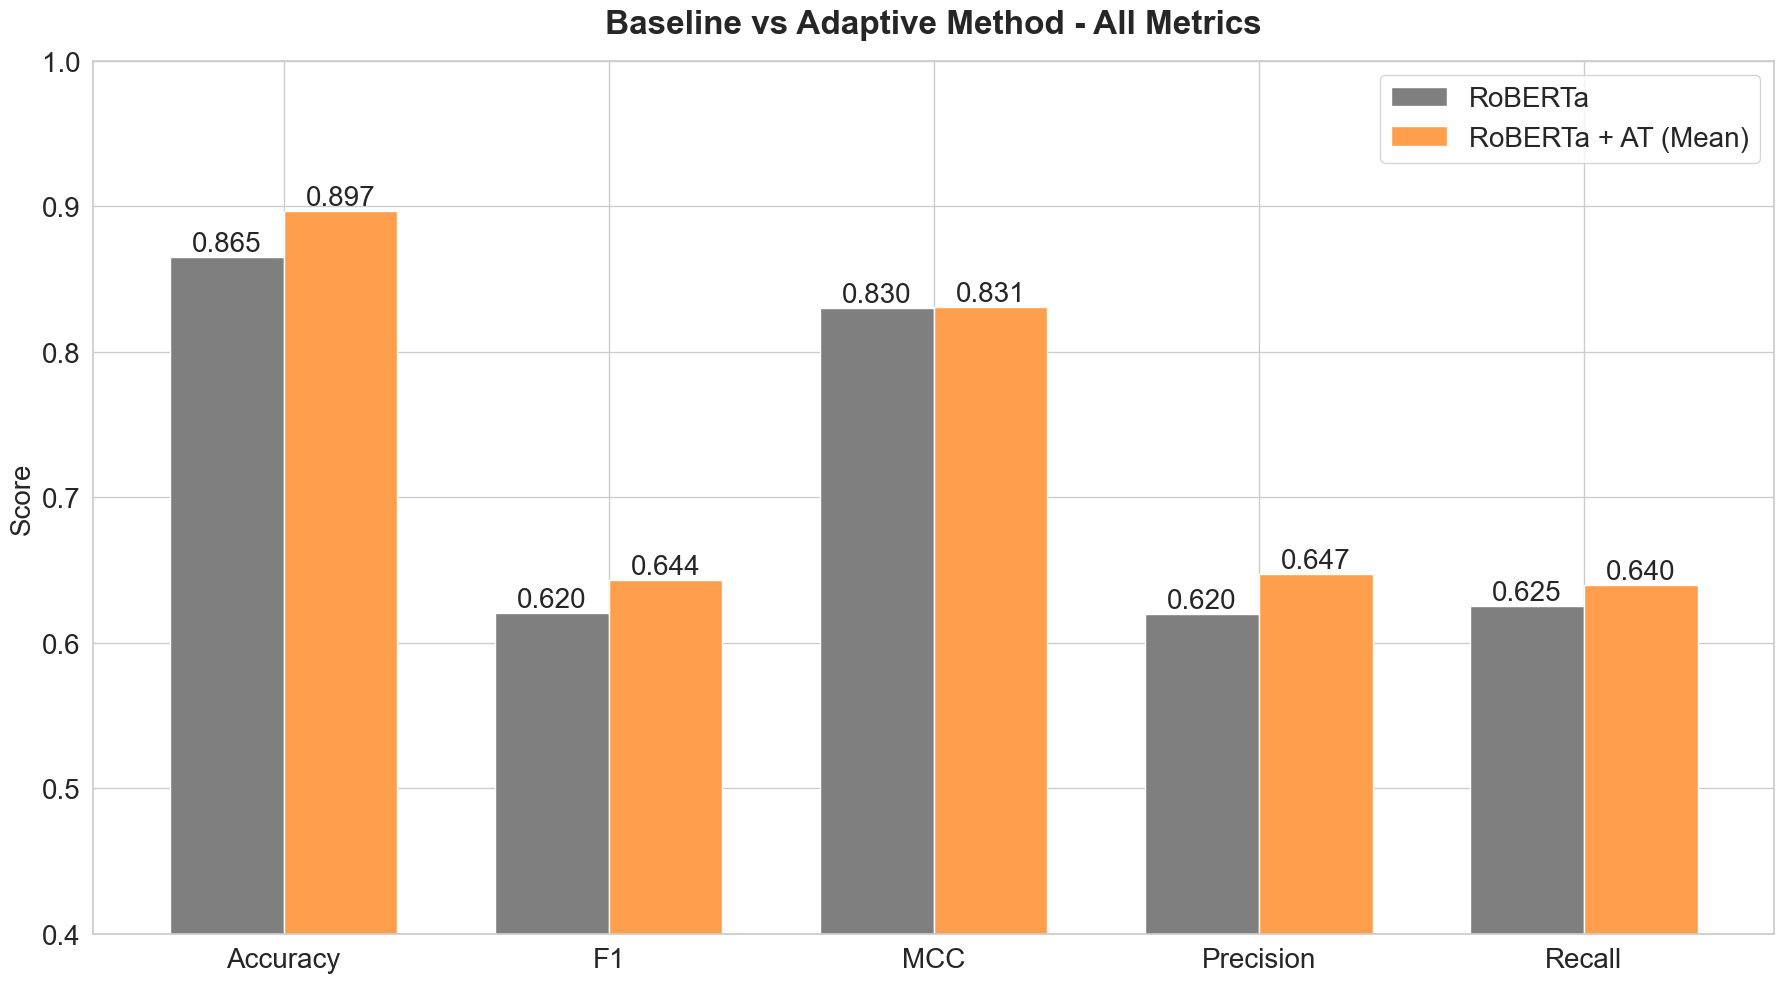

In [6]:
sns.set_theme(style="whitegrid")
colors = ['#7f7f7f', '#ff9f4e']  # [grey, orange]
# colors = sns.color_palette("Set2", 2)

# Metrics and corresponding values for Base and Adapt
metrics = [
    #"Loss", 
    "Accuracy", "F1", "MCC",
    "Precision", "Recall"
]

# Get values for both models
base_values = [eval_metrics[metric][0] for metric in metrics]
adapt_values = [eval_metrics[metric][1] for metric in metrics]

# Set up bar positions
x = np.arange(len(metrics))  # one position per metric
width = 0.35  # width of each bar

fig, ax = plt.subplots(figsize=(18, 10))
ax.set_ylim(0.4, 1.0)
# Plot both sets of bars
bars1 = ax.bar(x - width/2, base_values, width, label='RoBERTa', color=colors[0])
bars2 = ax.bar(x + width/2, adapt_values, width, label='RoBERTa + AT (Mean)', color=colors[1])

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Score', fontsize = 20)
ax.set_title('Baseline vs Adaptive Method - All Metrics', fontweight = 'bold', loc='center',pad=20.0, fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(metrics, ha='center', fontsize = 20)
ax.legend(fontsize = 20)

ax.tick_params(axis='y', labelsize=20)

# Add data labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.3f}",
                ha='center', va='bottom', fontsize=20)

plt.tight_layout()
plt.savefig('/Users/vedantmahangade/Projects/domain_adaptive_llm/output/plots/' + 'medical_all_eval_metrics.jpg', dpi=300)
plt.show()

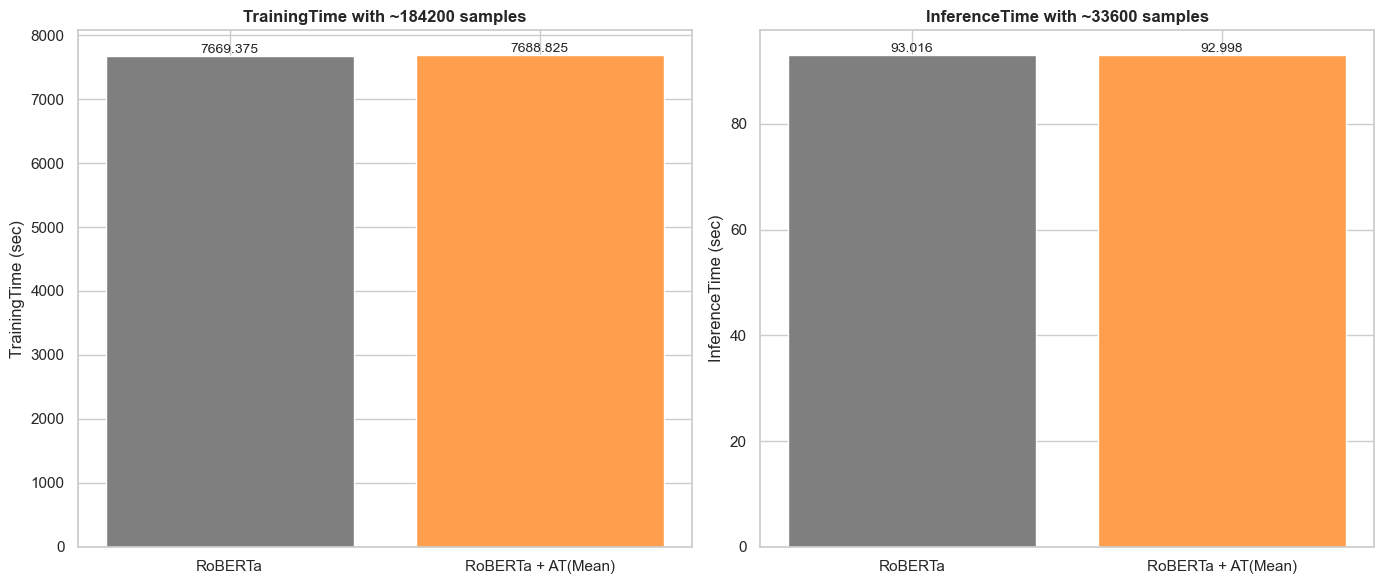

In [7]:
sns.set_theme(style="whitegrid")
colors = ['#7f7f7f', '#ff9f4e']  # [grey, orange]
# colors = sns.color_palette("Set2", 2)

metrics = [
    "TrainingTime", "InferenceTime"
]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs = axs.flatten()
sample = ['184200', '33600']
for i, metric in enumerate(metrics):
    values = [eval_metrics[metric][0], eval_metrics[metric][1]]
    bars = axs[i].bar(["RoBERTa", "RoBERTa + AT(Mean)"], values, color=colors)
    axs[i].set_title(metric + " with ~"+ sample[i] + " samples", fontweight = 'bold')
    axs[i].set_ylabel(metric + " (sec)")

    # Add value labels on each bar
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.3f}", 
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/Users/vedantmahangade/Projects/domain_adaptive_llm/output/plots/' + 'medical_train_infer_times.jpg', dpi=300)
plt.show()

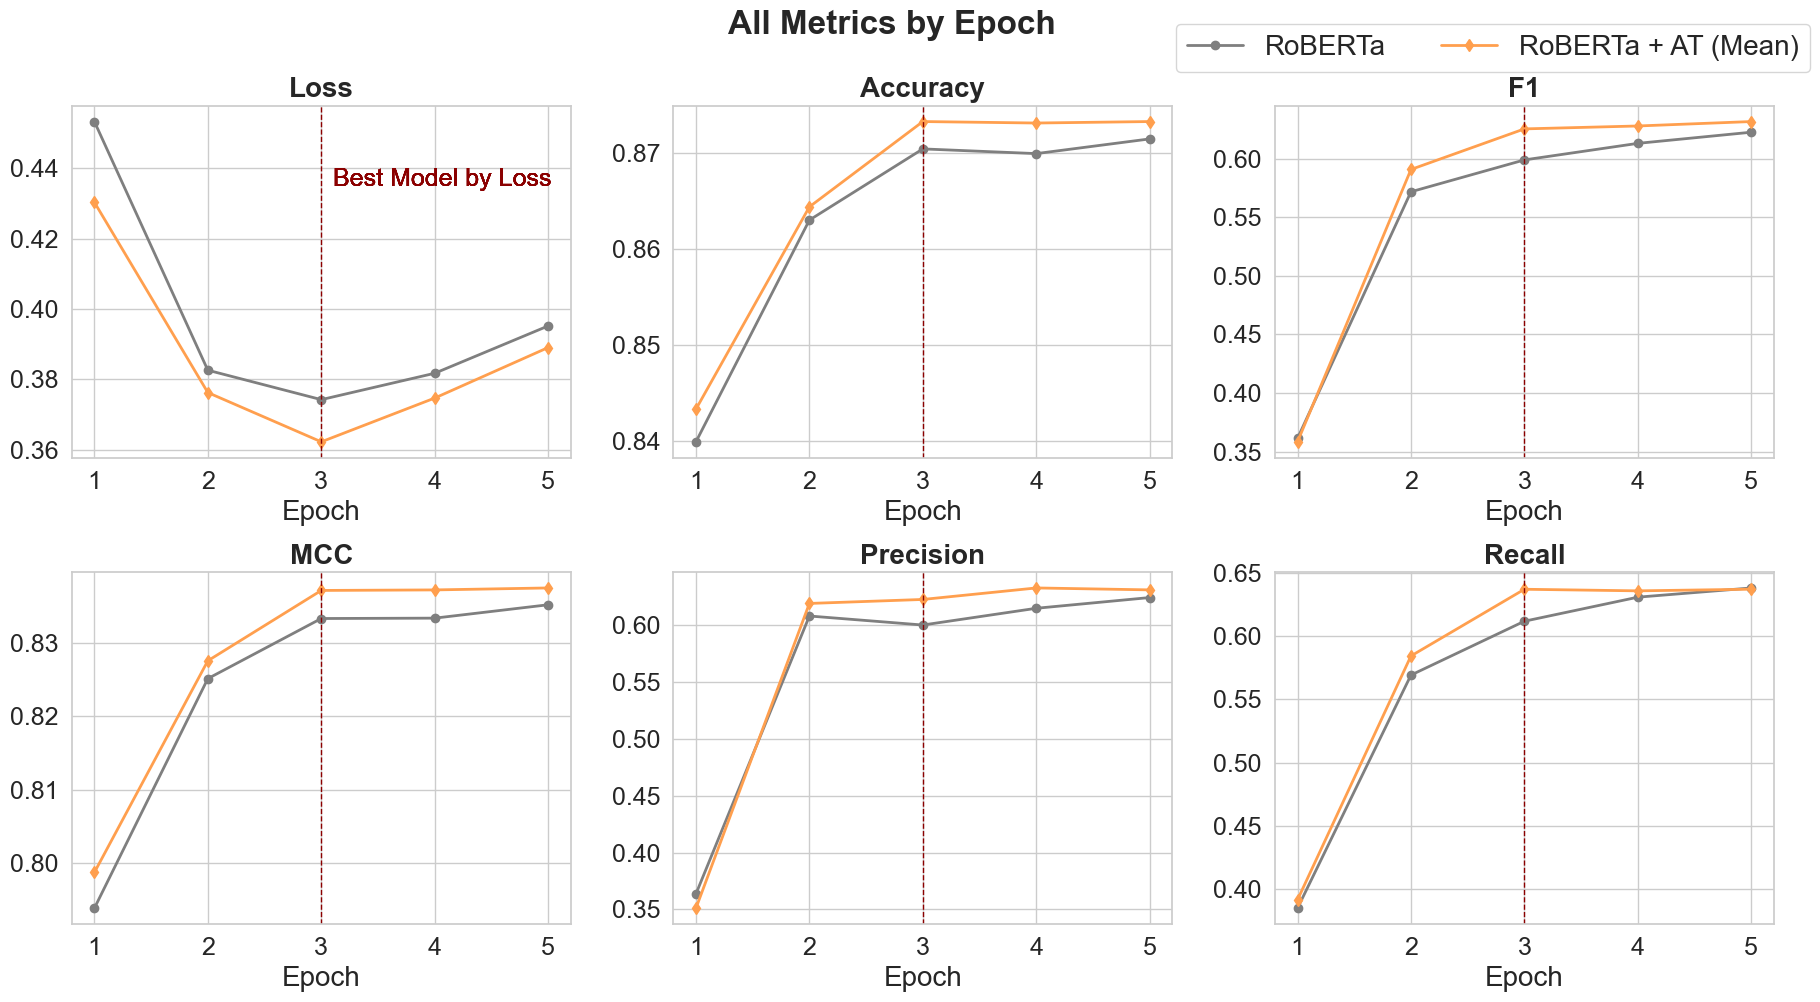

In [8]:
sns.set_theme(style="whitegrid")
colors = ['#7f7f7f', '#ff9f4e']  # [grey, orange]
# colors = sns.color_palette("Set2", 2)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
metrics = ["Loss", "Accuracy", "F1", "MCC", "Precision", "Recall"]

for i, metric in enumerate(metrics):
    epochs_base, base_score = baseline_model_metrics['Epoch'].to_list(), baseline_model_metrics[metric].to_list()
    epochs_adapt, adapt_score = adaptive_model_metrics['Epoch'].to_list(), adaptive_model_metrics[metric].to_list()

    axs[i].plot(epochs_base, base_score, label="RoBERTa", color=colors[0], marker='o', linewidth = 2)
    axs[i].plot(epochs_adapt, adapt_score, label="RoBERTa + AT (Mean)", color=colors[1], marker='d', linewidth = 2)
    axs[i].set_title(metric, fontsize = 20, fontweight = 'bold')
    axs[i].set_xlabel("Epoch", fontsize = 20)
    # axs[i].set_ylabel(metric, fontsize = 20)
    # Add vertical line at Epoch 3
    axs[i].axvline(x=3, color='darkred', linestyle='--', linewidth=1)
    axs[0].text(3 + 0.1, axs[0].get_ylim()[1]*0.95, 'Best Model by Loss', rotation=0, color='darkred', fontsize=18)#, fontweight = 'bold')
    axs[i].tick_params(axis='x', labelsize=18)
    axs[i].tick_params(axis='y', labelsize=18)
    # axs[i].legend()

# Extract handles and labels from the first axes only
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize=20, bbox_to_anchor=(0.65, 1))

fig.suptitle('All Metrics by Epoch', fontsize=24, y=1, fontweight = 'bold')

plt.tight_layout()
plt.savefig('/Users/vedantmahangade/Projects/domain_adaptive_llm/output/plots/' + 'medical_all_metrics_by_epoch.jpg', dpi=300)
plt.show()

# Financial Benchmarking

In [9]:
log_path = '/Users/vedantmahangade/Projects/domain_adaptive_llm/output/results/financial_benchmarking/log.csv'

eval_metrics = pd.read_csv(log_path)
eval_metrics

,Run Name,Loss,Accuracy,F1,MCC,Precision,Recall,TrainingTime,InferenceTime
0,fin_with_adapt_small,0.264635,0.930828,0.925002,0.887166,0.927618,0.922559,3297.532632,27.466740
1,fin_without_adapt_small,0.286191,0.933926,0.929532,0.892264,0.930996,0.928000,3298.379848,27.908871
2,fin_without_adapt_large,0.309855,0.938625,0.933101,0.900003,0.934815,0.931542,10138.594962,84.449223


In [10]:
path = '/Users/vedantmahangade/Projects/domain_adaptive_llm/output/results/financial_benchmarking/'

baseline_model_metrics = extract_eval_value(load_metric_data(path + 'fin_without_adapt_small.json'))
adaptive_model_metrics = extract_eval_value(load_metric_data(path + 'fin_with_adapt_small.json'))
target_model_metrics = extract_eval_value(load_metric_data(path + 'fin_without_adapt_large.json'))


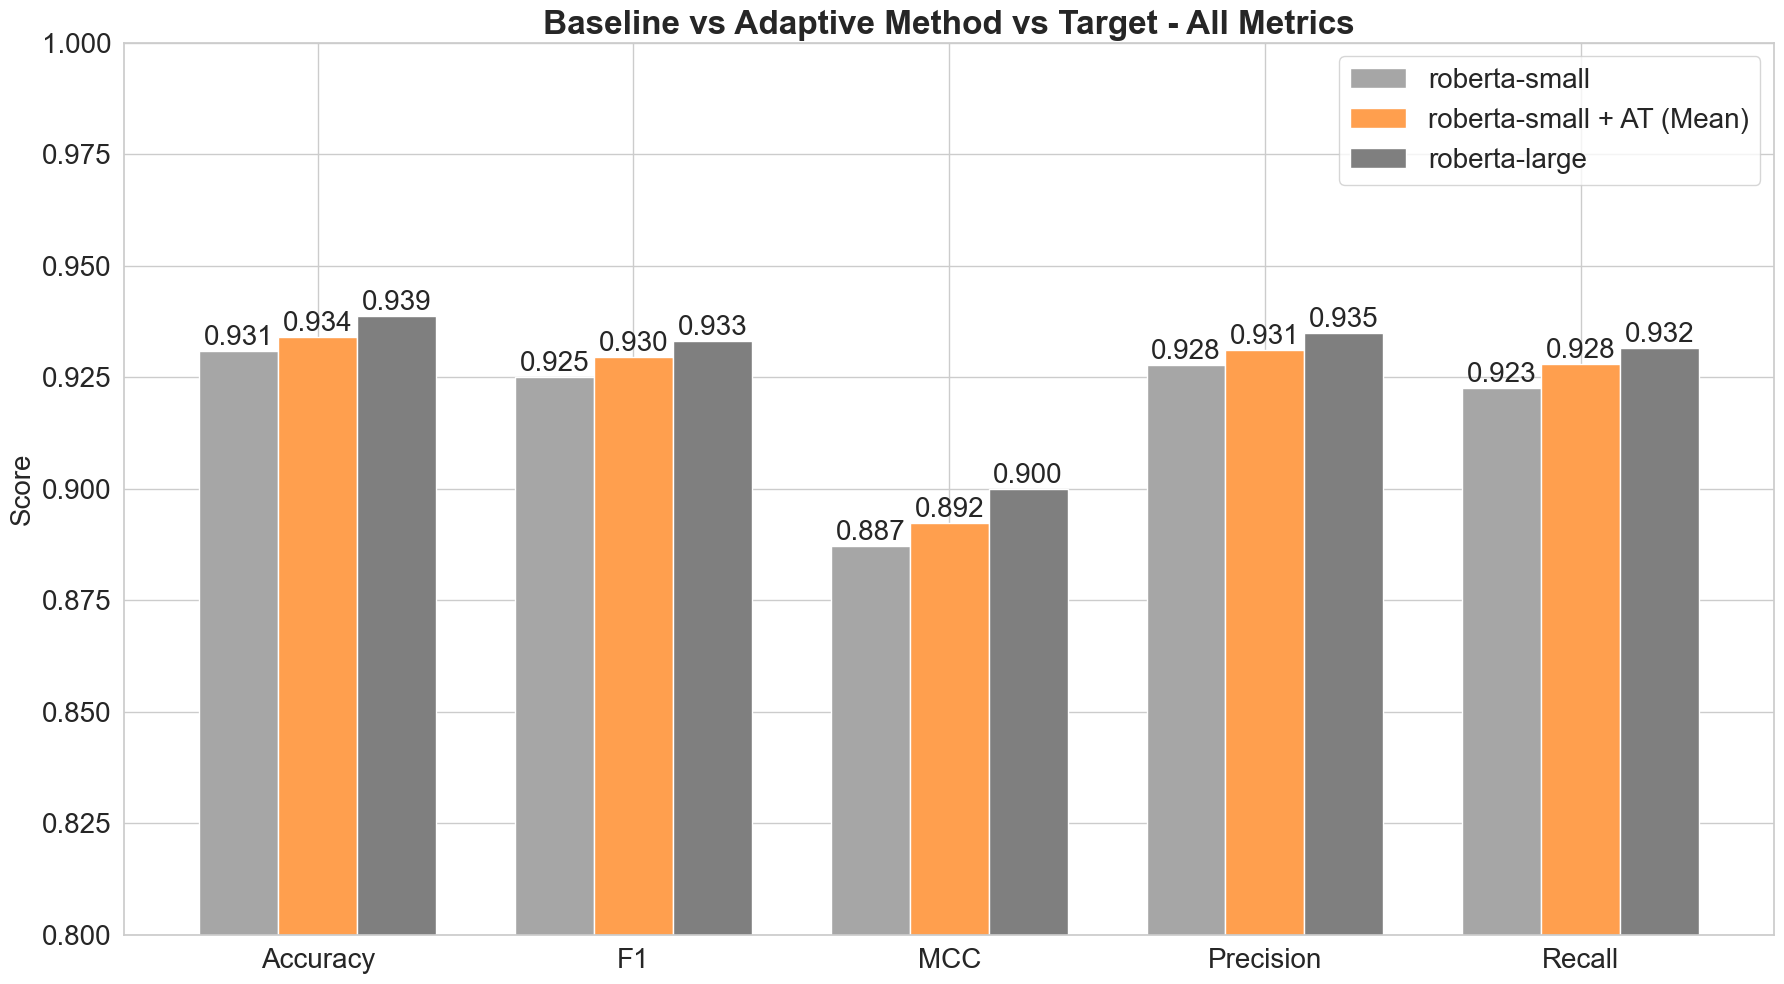

In [11]:
sns.set_theme(style="whitegrid")
colors = ['#a6a6a6', '#ff9f4e', '#7f7f7f']  # [light grey, orange, grey]
# colors = sns.color_palette("Set2", 2)

# Metrics and corresponding values for Base and Adapt
metrics = [
    #"Loss", 
    "Accuracy", "F1", "MCC",
    "Precision", "Recall"
]

# Get values for both models
base_values = [eval_metrics[metric][0] for metric in metrics]
adapt_values = [eval_metrics[metric][1] for metric in metrics]
target_values = [eval_metrics[metric][2] for metric in metrics]

# Set up bar positions
x = np.arange(len(metrics))  # one position per metric
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(18, 10))
ax.set_ylim(0.8, 1.0)
# Plot both sets of bars
bars1 = ax.bar(x - width, base_values, width, label='roberta-small', color=colors[0])
bars2 = ax.bar(x, adapt_values, width, label='roberta-small + AT (Mean)', color=colors[1])
bars3 = ax.bar(x + width, target_values, width, label='roberta-large', color=colors[2])

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Score', fontsize = 20)
ax.set_title('Baseline vs Adaptive Method vs Target - All Metrics', fontweight = 'bold', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(metrics, ha='center', fontsize = 20)
ax.legend(fontsize = 20)

ax.tick_params(axis='y', labelsize=20)

# Add data labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.3f}",
                ha='center', va='bottom', fontsize=20)

plt.tight_layout()
plt.savefig('/Users/vedantmahangade/Projects/domain_adaptive_llm/output/plots/' + 'financial_all_eval_metrics.jpg', dpi=300)
plt.show()

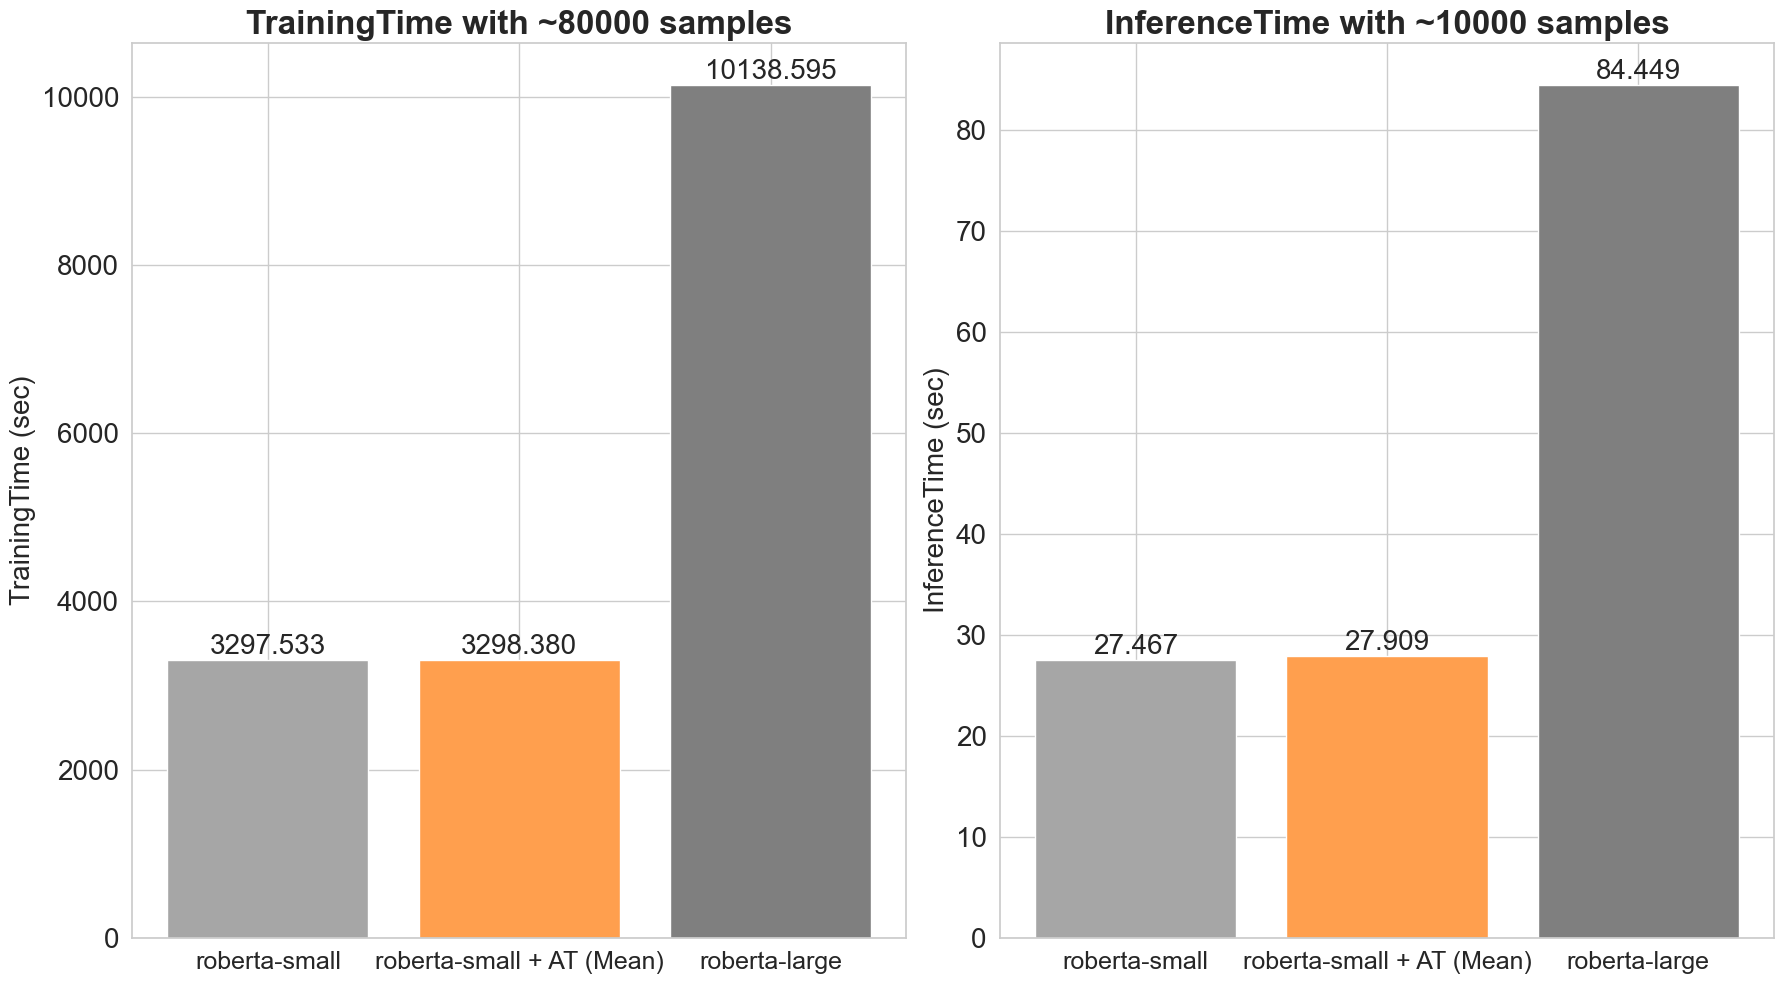

In [12]:
sns.set_theme(style="whitegrid")
colors = ['#a6a6a6', '#ff9f4e', '#7f7f7f']  # [light grey, orange, grey]
# colors = sns.color_palette("Set2", 2)

metrics = [
    "TrainingTime", "InferenceTime"
]

fig, axs = plt.subplots(1, 2, figsize=(18, 10))
axs = axs.flatten()
sample = ['80000', '10000']
for i, metric in enumerate(metrics):
    values = [eval_metrics[metric][0], eval_metrics[metric][1], eval_metrics[metric][2]]
    bars = axs[i].bar(["roberta-small", "roberta-small + AT (Mean)", "roberta-large"], values, color=colors)
    axs[i].set_title(metric + " with ~"+ sample[i] + " samples", fontweight = 'bold', fontsize = 24)
    axs[i].set_ylabel(metric + " (sec)", fontsize=20)

    # Add value labels on each bar
    for bar in bars:
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.3f}", 
                    ha='center', va='bottom', fontsize=20)
    axs[i].tick_params(axis='y', labelsize=20)
    axs[i].tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.savefig('/Users/vedantmahangade/Projects/domain_adaptive_llm/output/plots/' + 'financial_train_infer_time.jpg', dpi=300)
plt.show()

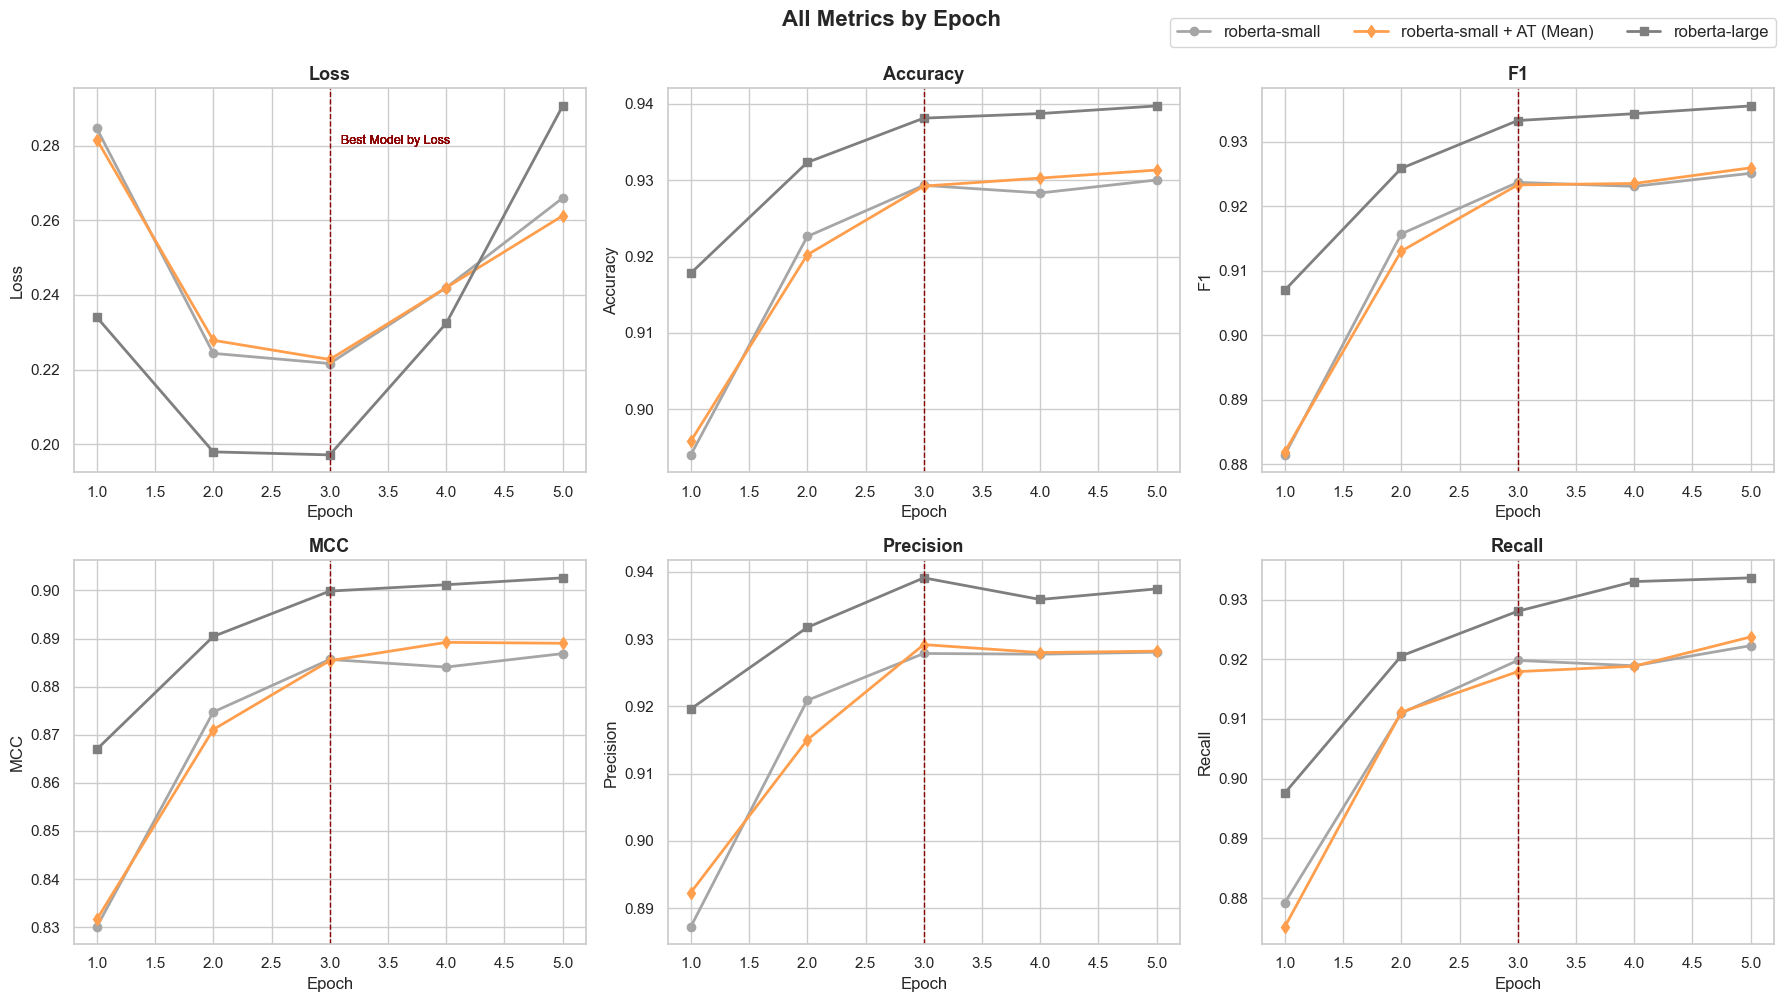

In [13]:
sns.set_theme(style="whitegrid")
colors = ['#a6a6a6', '#ff9f4e', '#7f7f7f']  # [light grey, orange, grey]
# colors = sns.color_palette("Set2", 2)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
metrics = ["Loss", "Accuracy", "F1", "MCC", "Precision", "Recall"]

for i, metric in enumerate(metrics):
    epochs_base, base_score = baseline_model_metrics['Epoch'].to_list(), baseline_model_metrics[metric].to_list()
    epochs_adapt, adapt_score = adaptive_model_metrics['Epoch'].to_list(), adaptive_model_metrics[metric].to_list()
    epochs_target, target_score = target_model_metrics['Epoch'].to_list(), target_model_metrics[metric].to_list()

    axs[i].plot(epochs_base, base_score, label="roberta-small", color=colors[0], marker='o', linewidth = 2)
    axs[i].plot(epochs_adapt, adapt_score, label="roberta-small + AT (Mean)", color=colors[1], marker='d', linewidth = 2)
    axs[i].plot(epochs_target, target_score, label="roberta-large", color=colors[2], marker='s', linewidth = 2)
    axs[i].set_title(metric, fontsize = 13, fontweight = 'bold')
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
    # axs[i].legend()
    # Add vertical line at Epoch 3
    axs[i].axvline(x=3, color='darkred', linestyle='--', linewidth=1)
    axs[0].text(3 + 0.1, axs[0].get_ylim()[1]*0.95, 'Best Model by Loss', rotation=0, color='darkred', fontsize=9)#, fontweight = 'bold')

# Extract handles and labels from the first axes only
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=12, bbox_to_anchor=(0.65, 1))

fig.suptitle('All Metrics by Epoch', fontsize=16, y=1, fontweight = 'bold')
plt.tight_layout()
plt.savefig('/Users/vedantmahangade/Projects/domain_adaptive_llm/output/plots/' + 'financial_all_metrics_by_epoch.jpg', dpi=300)
plt.show()

# Token Importance

In [14]:
import os
import csv
import time
import torch
from torch.utils.data import DataLoader, Dataset
import sklearn
import argparse
import numpy as np
import pandas as pd
# from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Tuple, Union
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, RobertaTokenizer, TrainingArguments, Trainer

In [15]:
# Adapt Tokenizer and Model for new domain tokens
def adapt_model_and_tokenizer(new_tokens, tokenizer_base, tokenizer_adapt, model_base, model_adapt):
    # add tokens to tokenizer
    tokenizer_adapt.add_tokens(new_tokens)

    # identify tokens which were skipped
    added = []
    skipped = []
    for tok in new_tokens:
      if tok in tokenizer_adapt.get_vocab():
          added.append(tok)
      else:
          skipped.append(tok)

    print("Added", len(added), "tokens")
    print("Skipped", len(skipped), "tokens")

    # force add skipped tokens
    if len(skipped) > 0:
        tokenizer_adapt.add_tokens(skipped)

    # resize model's embeding layer (this assigns random embeddings)
    model_adapt.resize_token_embeddings(len(tokenizer_adapt))

    # adapt model
    with torch.no_grad():
        # for each token in new tokens, get mean of sub_token embeddings and assign them to the new model's respective token
        for token in new_tokens:
            # Sub tokens of new token from base tokenizer
            subwords = tokenizer_base.tokenize(token)
            # convert the subtokens to ids from base tokenizer
            subword_ids = tokenizer_base.convert_tokens_to_ids(subwords)

            # extract word embeddings for each subwords from base model
            subword_embeds = model_base.roberta.embeddings.word_embeddings.weight[subword_ids]

            # Compute the mean embedding for the new token
            mean_embed = torch.mean(subword_embeds, dim=0)

            # Assign the mean embedding to the new token in the new model
            token_id = tokenizer_adapt.convert_tokens_to_ids(token)
            model_adapt.roberta.embeddings.word_embeddings.weight[token_id] = mean_embed

    return tokenizer_adapt, model_adapt

In [ ]:
def get_token_importance_score(encoding, model, target_label=None):
    # Capture embedding gradients
    embedding_grads = []

    def save_grads_hook(module, grad_input, grad_output):
        embedding_grads.append(grad_output[0])

    # Hook the embedding layer
    hook = model.roberta.embeddings.register_full_backward_hook(save_grads_hook)

    # Forward pass (capture hidden states too!)
    outputs = model(**encoding, output_hidden_states=True)
    logits = outputs.logits
    hidden_states = outputs.hidden_states[0]  # Embedding output

    probs = torch.softmax(logits, dim=-1)
    if target_label is None:
        target_label = torch.argmax(probs, dim=-1).item()

    # Backward
    model.zero_grad()
    loss = logits[0, target_label]
    loss.backward()

    # Clean up hook
    hook.remove()

    grads = embedding_grads[0][0]         # [seq_len, hidden_dim]
    embeds = hidden_states[0]

    grad_times_input = grads * embeds # Grad x Input
    token_importance = grad_times_input.norm(dim=-1)  # L2 norm per token

    # tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return token_importance.cpu().detach().numpy()


In [29]:
def visualize(scores, tokens, name):
    # Expand tokens into characters
    # chars = ''.join(tokens).replace('Ġ',' ')
    # char_list = list(chars)

    # Repeat scores according to token lengths
    # expanded_scores = []
    # for score, token in zip(scores, tokens):
    #     expanded_scores.extend([score] * len(token))

    # Create a figure
    # fig, ax = plt.subplots(figsize=(len(char_list)*0.4, 2))
    fig, ax = plt.subplots(figsize=(18, 5))

    # Create a heatmap
    # heatmap_data = np.array([expanded_scores])
    heatmap_data = np.array([scores])
    sns.heatmap(
        heatmap_data,
        cmap='flare',
        cbar=True,
        vmin=scores.min(), vmax=scores.max(),

        # xticklabels=char_list,
        xticklabels=tokens,
        yticklabels=[],
        linewidths=0.5,
        linecolor='black',
        ax=ax
    )

    # Customize plot
    plt.xticks(rotation=30, fontsize = 20)
    ax.set_title(name, fontsize = 24, fontweight = 'bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.show()
    # plt.savefig(name, dpi=300, bbox_inches='tight')

In [18]:
tokenizer_base = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
tokenizer_adapt = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
model_base = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=5)
model_adapt = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
new_tokens = pd.read_csv("/Users/vedantmahangade/Projects/domain_adaptive_llm/output/results/medical_benchmarking/new_tokens_med.txt", header=None)[0].tolist()

sentence = 'The location of epithelial cell determines its function.'

In [20]:
tokenizer_adapt, model_adapt = adapt_model_and_tokenizer(new_tokens, tokenizer_base, tokenizer_adapt, model_base, model_adapt)

Added 7438 tokens
Skipped 0 tokens


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [21]:
encoding = tokenizer_base(sentence, return_tensors="pt", truncation = True,return_attention_mask=True, return_token_type_ids=True)
scores_1 = get_token_importance_score(encoding, model_base)[1:-1]  # e.g., IG or Grad × Input
tokens_1 = tokenizer_base.tokenize(sentence)

In [22]:
encoding = tokenizer_adapt(sentence, return_tensors="pt", truncation = True,return_attention_mask=True, return_token_type_ids=True)
scores_2 = get_token_importance_score(encoding, model_adapt)[1:-1]  # e.g., IG or Grad × Input
tokens_2 = tokenizer_adapt.tokenize(sentence)

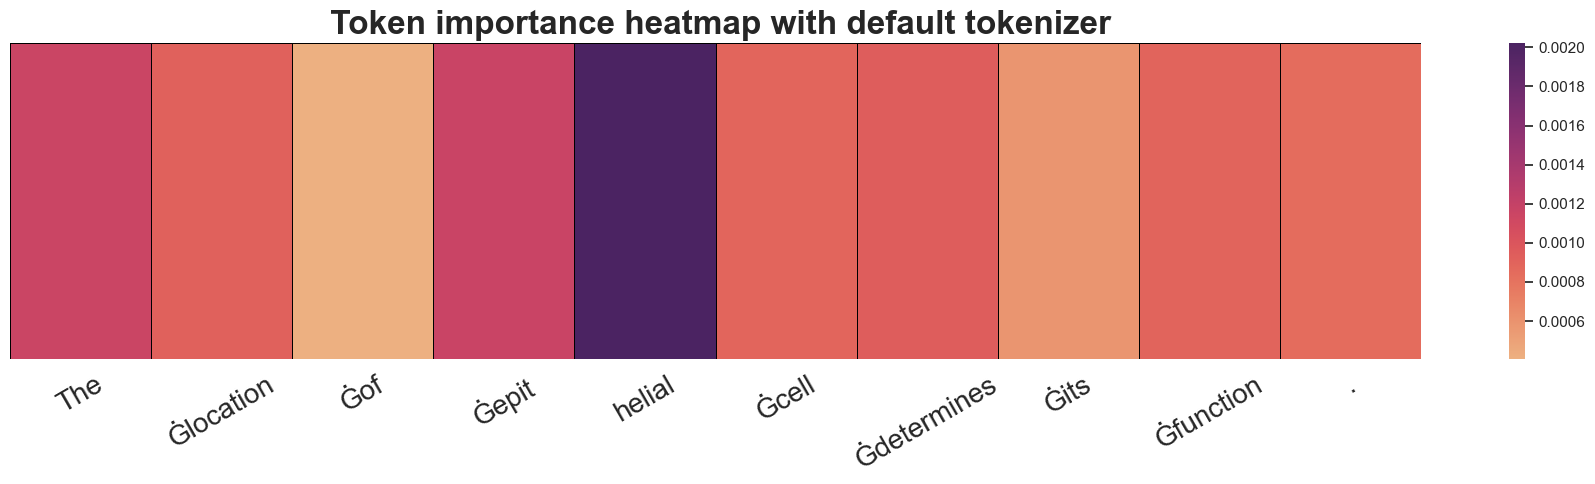

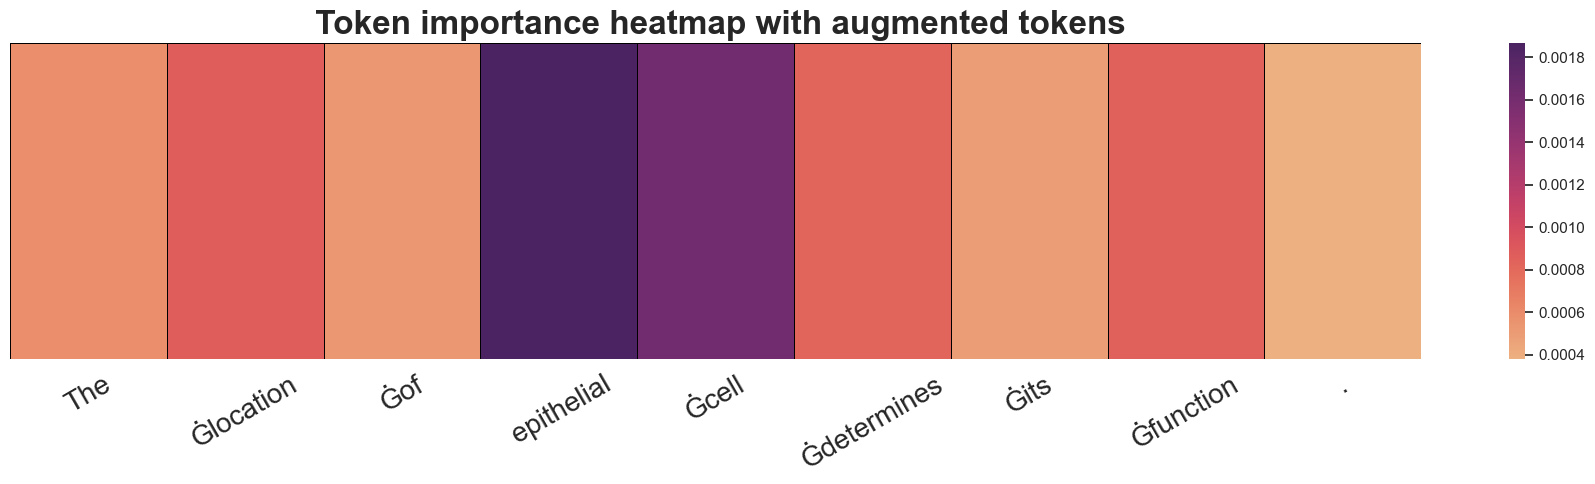

In [30]:
visualize(scores_1, tokens_1, ' Token importance heatmap with default tokenizer')
visualize(scores_2, tokens_2, ' Token importance heatmap with augmented tokens')